# applied statistical methods for quantitative finance

### orko sarkar

today we will run through some basic statistical concepts used in quantitative finance. 
after discussing the theory at a high level we will explore some packages that allow us to easily implement the concepts involved, making sure to highlight and discuss the flaws in the assumptions we make along the way (and there are many). 
while you won't leave this talk with a tradable strategy, you'll have a good idea of where to start.

## why should you listen to me?

## stationarity

### what is stationarity?


**stationarity** is an important property of time series. as traders, our interest in stationarity is because if we can find a stationary time series, it has the potential to be tradable. so, what is this important property? googling it, we find many different types of stationarity - strong, weak, differenced, trend.

the academic definition of (strong) stationarity is a time series where the distribution of the random variable is time invariant. 

weak stationarity is a time series in which the mean, variance, and autocorrelation are time invariant.

a more applied definition - a time series which diffuses from the mean at a rate which is slower than a random walk. this provides us some insight into why stationarity is useful.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

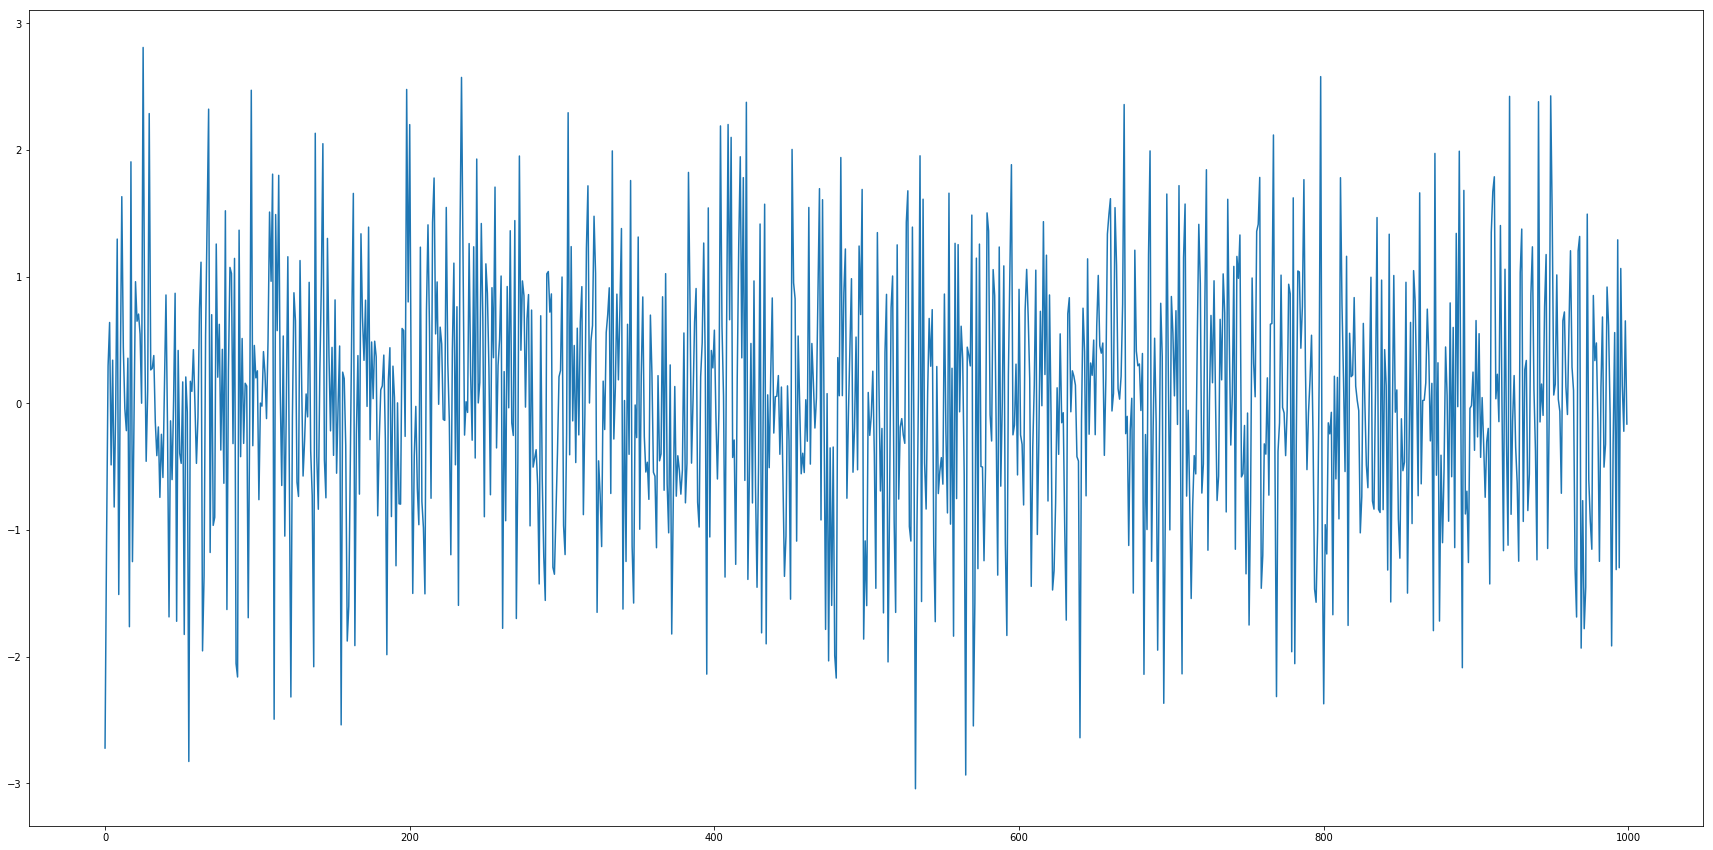

In [19]:
white_noise = np.random.normal(0, 1, size=1000)
plt.figure(figsize=(30,15))
plt.plot(white_noise)

In [3]:
import statsmodels.tsa.stattools as ts 
def adf(series):
    stationary = ts.adfuller(series)
    print('p value : ' +  str(stationary[1]))
    print('test statistic: ' +  str(stationary[0]))
    print ('critical values: ',end='')
    for s in ['1%','5%','10%']:
        print(s + ': ' + str(stationary[4][s]) + ' | ',end='')

In [4]:
adf(white_noise)

p value : 0.0
test statistic: -32.604465040327156
critical values: 1%: -3.4369127451400474 | 5%: -2.864437475834273 | 10%: -2.568312754566378 | 

### does this seem realistic?

In [5]:
crypto = pd.read_csv('crypto-markets.csv')
btc = crypto[crypto['name']=='Bitcoin'].set_index('date')
btc.index = pd.to_datetime(btc.index)

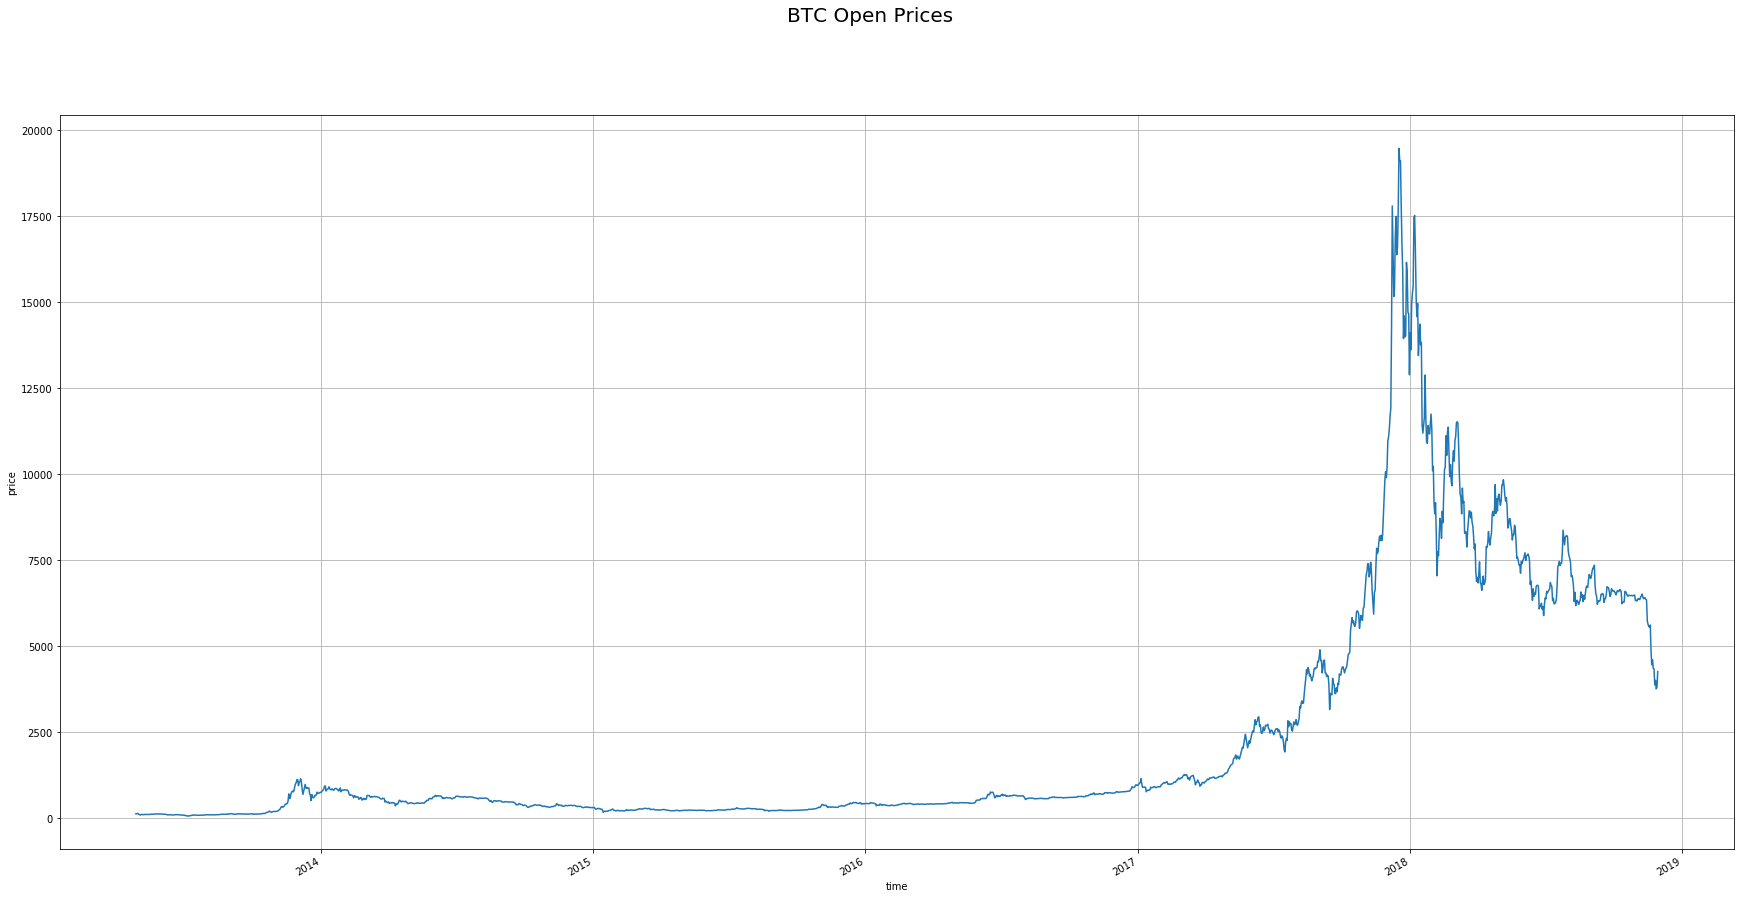

In [6]:
fig,ax = plt.subplots(figsize=(30,15))
ax.plot(btc['open'])
fig.suptitle('BTC Open Prices', fontsize=20)
fig.patch.set_facecolor('white')
ax.xaxis.set_label_text('time')
ax.yaxis.set_label_text('price')
ax.grid(True)
fig.autofmt_xdate()
plt.show()

In [7]:
adf(btc['open'])

p value : 0.2765383431121482
test statistic: -2.0230975594455596
critical values: 1%: -3.4335946172657774 | 5%: -2.8629733042364576 | 10%: -2.567533028727577 | 

**no.** pretty much no time series you find in the real world will fulfill the criteria strong stationarity, and in financial data little to none will exhibit weak stationarity (in a useful way). this happens because of efficient markets - its very easy to check if a time series is stationary, so any individual stationary time series won't exhibit behavior useful to trade (or else people would trade it, and that behavior would disappear)

### so what can we do?

thankfully, we aren't limited to trading a single product. if we combine two time series, we might be able to construct a portfolio of products which is stationary.

## cointegration

we call a portfolio of products which when combined in a very specific way are stationary **cointegrating**

if we can find a pair (or more) of cointegrating products, we know they can be combined into a stationary time series.

as we'll see, this can be quite easy to do with the combination of some intuition and some useful python packages.

## whats something that might cointegrate with bitcoin?

ethereum! lets see if bitcoin and ethereum cointegrate:

In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [9]:
crypto = pd.read_csv('crypto-markets.csv')
btc = crypto[crypto['name']=='Bitcoin'].set_index('date')
eth = crypto[crypto['name']=='Ethereum'].set_index('date')
btc = btc['2016-01-01':]#'2017-07-01']
eth = eth['2016-01-01':]#'2017-07-01']
btc.index = pd.to_datetime(btc.index)
eth.index = pd.to_datetime(eth.index)
data = pd.DataFrame(btc['open']).merge(pd.DataFrame(eth['open']), on='date')

In [10]:
ts.coint(btc['open'],eth['open'])

(-4.766090984359659,
 0.0004328831376579418,
 array([-3.90677249, -3.34188402, -3.04844225]))

In [11]:
x = coint_johansen(data,0,1)

In [12]:
teststat = pd.DataFrame(x.cvt, columns=['90%','95%', '99%'])
teststat['test statistic'] = pd.DataFrame(x.lr1)
print(teststat)

       90%      95%      99%  test statistic
0  13.4294  15.4943  19.9349       30.964678
1   2.7055   3.8415   6.6349        3.868811


In [13]:
eigenstat = pd.DataFrame(x.cvm, columns=['90%','95%', '99%'])
eigenstat['max eigenvalue statistic'] = pd.DataFrame(x.lr2)
print(eigenstat)

       90%      95%      99%  max eigenvalue statistic
0  12.2971  14.2639  18.5200                 27.095867
1   2.7055   3.8415   6.6349                  3.868811


btc and eth **do cointegrate**! so, we can make a stationary portfolio by trading btc and eth at the right time (???) in a ratio given to us by eigenvectors of the Johansen test

In [14]:
print(x.evec)

[[ 0.00055298 -0.00014438]
 [-0.00791624 -0.00157445]]


## what is the right time? - mean reversion

whenever the price of our portfolio deviates too far from its own mean, we can buy (if the price is lower than the mean) or sell (if the price is higher than the mean) and count on it to "revert" to the mean

In [15]:
# btc = crypto[crypto['name']=='Bitcoin'].set_index('date')
# eth = crypto[crypto['name']=='Ethereum'].set_index('date')
# btc = btc['2017-07-01':]
# eth = eth['2017-07-01':]
# btc.index = pd.to_datetime(btc.index)
# eth.index = pd.to_datetime(eth.index)
# data = pd.DataFrame(btc['open']).merge(pd.DataFrame(eth['open']), on='date')
coint = (btc['open']*x.evec[0][0]) + (eth['open']*x.evec[1][0])
coint30daymean = coint.rolling(window=15).mean().shift()
coint30daystd = coint.rolling(window=15).std().shift()
upper = coint30daymean + coint30daystd*2
lower = coint30daymean - coint30daystd*2

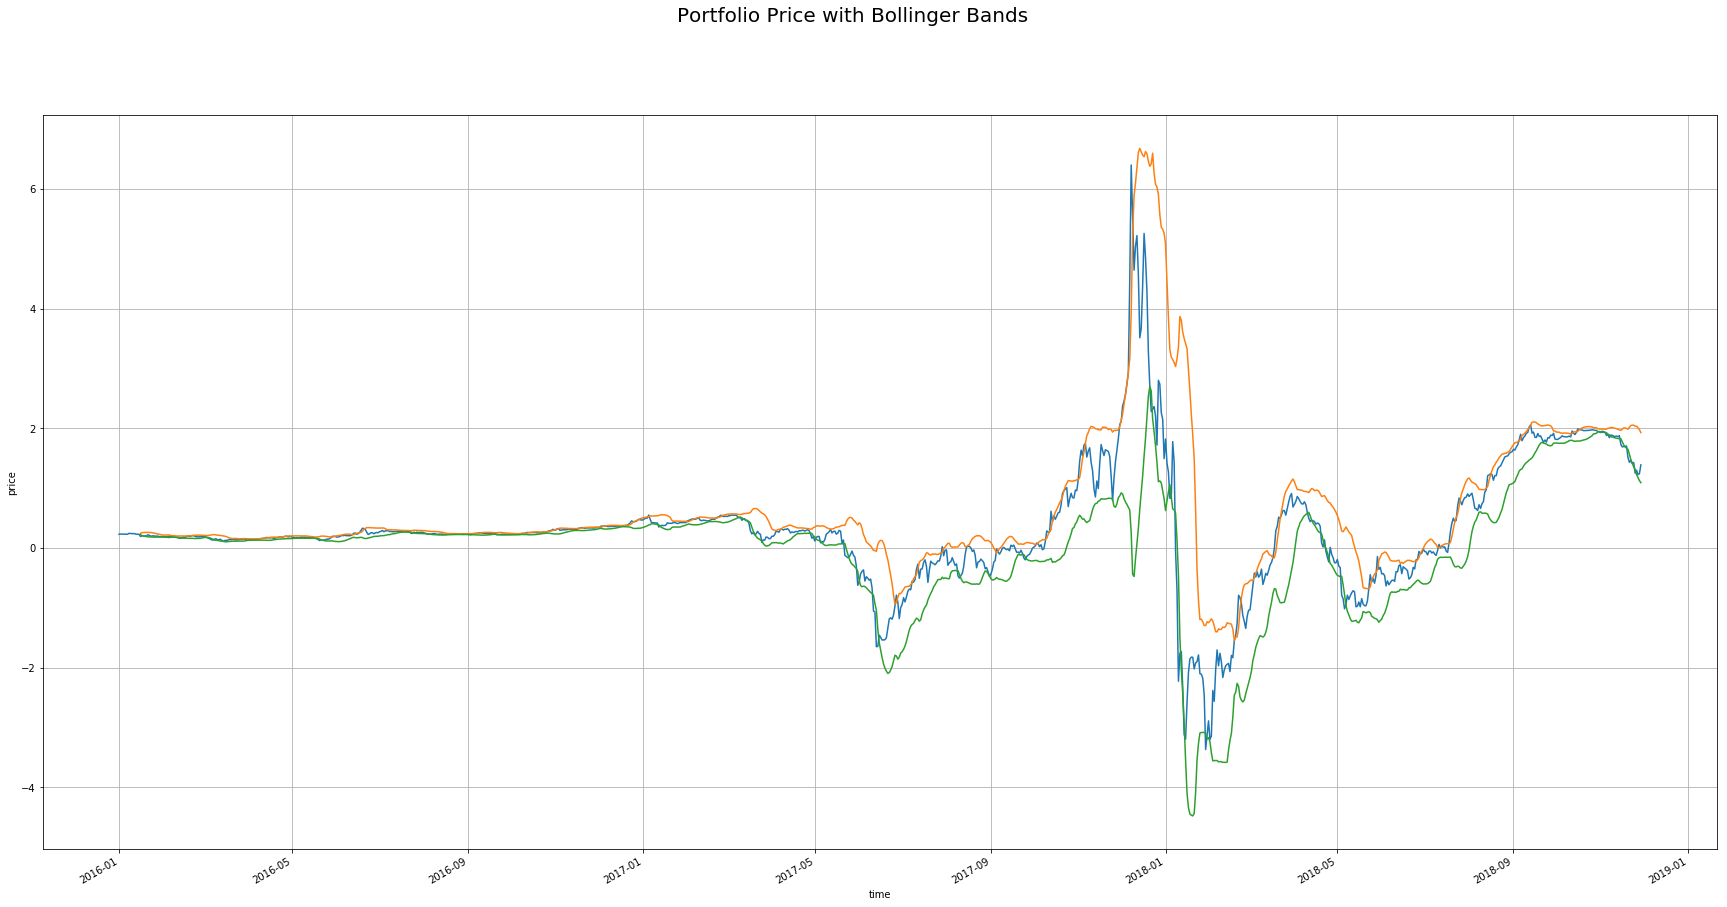

In [16]:
fig,ax = plt.subplots(figsize=(30,15))
ax.plot(coint)
ax.plot(upper)
ax.plot(lower)
fig.suptitle('Portfolio Price with Bollinger Bands', fontsize=20)
fig.patch.set_facecolor('white')
ax.xaxis.set_label_text('time')
ax.yaxis.set_label_text('price')
ax.grid(True)
fig.autofmt_xdate()
plt.show()

In [17]:
from datetime import datetime
# holding - 0 = nothing, 1 = long, 2 = short
holding = revert = price = pnl = units = trades = goodtrades=0 
date = None
capital = 10
daily = []
dates = []
for i in coint.index:
    if units ==0:
        daily.append(capital)
    elif holding == 1:
        daily.append(capital + units*(coint[i]-price))
    elif holding == 2:
        daily.append(capital + units*(price - coint[i]))
    if holding == 1:
        if coint[i] >= revert:
            capital += units*(coint[i]-price)
            holding = units = 0
            goodtrades += 1
#         elif (i - date).days > 2:
#             capital += units*(coint[i]-price)
#             holding = units = 0
    elif holding == 2:
        if coint[i]<= revert:
            capital += units*(price - coint[i])
            holding =units = 0
            goodtrades += 1
#         elif (i - date).days > 2:
#             capital += units*(price - coint[i])
#             holding =units = 0
    elif coint[i] > upper[i]:
        holding = 2
        price = coint[i]
        units = capital/price
        revert = upper[i]
        date = i
        trades += 1
        dates.append(date.strftime('%m/%d/%Y'))
    elif coint[i] < lower[i]:
        holding = 1
        price = coint[i]
        units = capital/price
        revert = lower[i]
        date = i
        trades += 1
        dates.append(date.strftime('%m/%d/%Y'))

if holding == 1:
    capital += units*(coint[i]-price)
    holding = 0
elif holding == 2:
    capital += units*(price - coint[i])
    holding = 0

print('summary:')
print('---------------------------------------------------')
print('number of trades: ' + str(trades))
print('dates traded:' + str(dates))
print('final capital: %.2f' % capital)
print('pnl: %.2f%%' % ((capital-10)*100/10))

summary:
---------------------------------------------------
number of trades: 19
dates traded:['01/16/2016', '06/13/2016', '09/03/2016', '09/05/2016', '09/20/2016', '10/08/2016', '03/19/2017', '04/07/2017', '04/28/2017', '05/12/2017', '05/22/2017', '10/10/2017', '01/09/2018', '03/20/2018', '04/21/2018', '04/23/2018', '05/04/2018', '05/29/2018', '06/25/2018']
final capital: 205.33
pnl: 1953.35%


## momentum

time series momentum just means that past returns are positively correlated with future returns.

if we find a time series where momentum exists, we can simply buy when we see prices going up, and sell when we see prices going down